# Autoencoders for Feature Extraction

We will use Autoencoders to extract features from a two-class dataset, thus making model training more efficient.

In [80]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

In [65]:
data = torch.randn((200,10))

In [66]:
batch_size = 40
dataload = DataLoader(data,batch_size=batch_size)

In [67]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10,5)
        self.layer2 = nn.Linear(5,2)
        self.layer3 = nn.Linear(2,5)
        self.out_layer = nn.Linear(5,10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.out_layer(x)
        return x

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 450
lr = 1e-3

model = AE()
print(model)

optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()

AE(
  (layer1): Linear(in_features=10, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=10, bias=True)
  (relu): ReLU()
)


In [69]:
model.to(device)

AE(
  (layer1): Linear(in_features=10, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=10, bias=True)
  (relu): ReLU()
)

In [70]:
model.train()
agg_loss = []
for epoch in range(1,n_epochs+1):
    epoch_loss = 0
    for x in dataload:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds,x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    epoch_loss = epoch_loss/len(dataload)
    agg_loss.append(epoch_loss)
    print(f'epoch: {epoch+0:03} | loss: {epoch_loss}')

epoch: 01 | loss: 1.1446658372879028
epoch: 02 | loss: 1.132506251335144
epoch: 03 | loss: 1.1210112571716309
epoch: 04 | loss: 1.1101592779159546
epoch: 05 | loss: 1.0999422073364258
epoch: 06 | loss: 1.0903079509735107
epoch: 07 | loss: 1.0812125205993652
epoch: 08 | loss: 1.0726416110992432
epoch: 09 | loss: 1.064573049545288
epoch: 10 | loss: 1.0568997859954834
epoch: 11 | loss: 1.0495511293411255
epoch: 12 | loss: 1.042548656463623
epoch: 13 | loss: 1.0358631610870361
epoch: 14 | loss: 1.029401421546936
epoch: 15 | loss: 1.023160696029663
epoch: 16 | loss: 1.0170928239822388
epoch: 17 | loss: 1.0111844539642334
epoch: 18 | loss: 1.0054361820220947
epoch: 19 | loss: 0.9998564720153809
epoch: 20 | loss: 0.9944108128547668
epoch: 21 | loss: 0.989056408405304
epoch: 22 | loss: 0.9838085174560547
epoch: 23 | loss: 0.9786102175712585
epoch: 24 | loss: 0.9735148549079895
epoch: 25 | loss: 0.9686083793640137
epoch: 26 | loss: 0.9637588262557983
epoch: 27 | loss: 0.9589062929153442
epoch: 

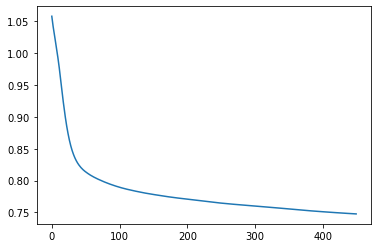

In [64]:
plt.plot(agg_loss)

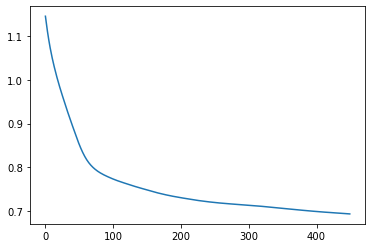

In [71]:
plt.plot(agg_loss)

# Reconstruct the Data

Before performing the feature extraction, we want to make sure the AE can actually fit the data. Rather than merely inspecting the reconstruction error (mean_squared_error), we will train a Logistic Regression model with the original data, then generate predictions with both the original and the AE-reconstructed test data, and compare performance.

If these two arrangements yield similar accuracy we can proceed to feature extraction.

We start by synthesizing the data:

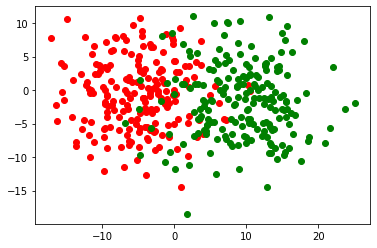

In [82]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

x,y = make_blobs(400,10,centers=2,cluster_std=5.5,random_state=33)
plt.scatter(x[y==0][:,0],x[y==0][:,1],c='red')
plt.scatter(x[y==1][:,0],x[y==1][:,1],c='green')

x_tr,x_ts,y_tr,y_ts = train_test_split(x,y,train_size=0.8,random_state=33)

We will first train and test a Logistic Regression with the original data to see what level of accuracy we might expect.

accuracy: 0.9875



<AxesSubplot:>

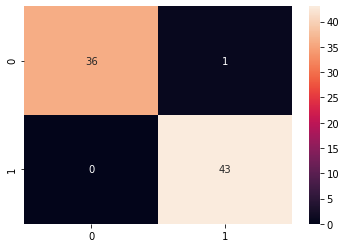

In [83]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_tr,y_tr)
preds = lr.predict(x_ts)

print('accuracy:', accuracy_score(y_ts,preds))
print('')
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d')

Import pytorch libraries.

In [22]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import optim

Transform data into tensors, and divide in batches using DataLoader class.

In [86]:
batch_size = 40
x_tr_tensor = torch.Tensor(x_tr)
dataload = DataLoader(x_tr_tensor,batch_size=batch_size)

Prepare autoencoder.

In [67]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10,5)
        self.layer2 = nn.Linear(5,2)
        self.layer3 = nn.Linear(2,5)
        self.out_layer = nn.Linear(5,10)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.out_layer(x)
        return x

Intialize parameters for model training.

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 200
lr = 1e-3

model = AE()

optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.MSELoss()

AE(
  (layer1): Linear(in_features=10, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=2, bias=True)
  (layer3): Linear(in_features=2, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=10, bias=True)
  (relu): ReLU()
)


Train the AE to reconstruct the data:

In [89]:
model.to(device)
model.train()
agg_loss = []
for epoch in range(1,n_epochs+1):
    epoch_loss = 0
    for x in dataload:
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds,x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    epoch_loss = epoch_loss/len(dataload)
    agg_loss.append(epoch_loss)
    print(f'epoch: {epoch+0:02} | loss: {epoch_loss}')

epoch: 01 | loss: 66.59320068359375
epoch: 02 | loss: 66.43514251708984
epoch: 03 | loss: 66.30167388916016
epoch: 04 | loss: 66.18617248535156
epoch: 05 | loss: 66.08313751220703
epoch: 06 | loss: 65.98766326904297
epoch: 07 | loss: 65.89725494384766
epoch: 08 | loss: 65.80912017822266
epoch: 09 | loss: 65.7220230102539
epoch: 10 | loss: 65.63478088378906
epoch: 11 | loss: 65.54547882080078
epoch: 12 | loss: 65.4535140991211
epoch: 13 | loss: 65.357421875
epoch: 14 | loss: 65.2541732788086
epoch: 15 | loss: 65.13800048828125
epoch: 16 | loss: 64.9879150390625
epoch: 17 | loss: 64.7735366821289
epoch: 18 | loss: 64.47189331054688
epoch: 19 | loss: 64.03861236572266
epoch: 20 | loss: 63.43179702758789
epoch: 21 | loss: 62.63402557373047
epoch: 22 | loss: 61.62556838989258
epoch: 23 | loss: 60.428646087646484
epoch: 24 | loss: 59.090980529785156
epoch: 25 | loss: 57.67995834350586
epoch: 26 | loss: 56.25261688232422
epoch: 27 | loss: 54.8243408203125
epoch: 28 | loss: 53.423580169677734


Plot loss curve:

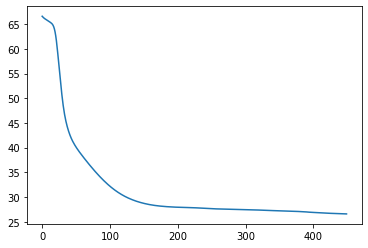

In [90]:
plt.plot(agg_loss)
plt.title('Loss Curve');

Use reconstructed data as test data for the logistic regression model. If it yields high accuracy the AE works and we can use it as a feature extractor.

accuracy: 0.9875



<AxesSubplot:>

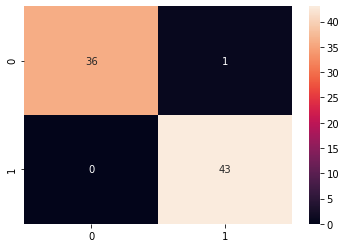

In [102]:
reconstructed = model(torch.Tensor(x_ts,))
reconstructed = reconstructed.detach().cpu().numpy()

lr = LogisticRegression()
lr.fit(x_tr,y_tr)
preds = lr.predict(reconstructed)

print('accuracy:', accuracy_score(y_ts,preds))
print('')
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d')

It yields good performance, and we will use it to extract features.

Let's us plot the reconstructed data first (first two features), to get a feel for how the AE worked on them.

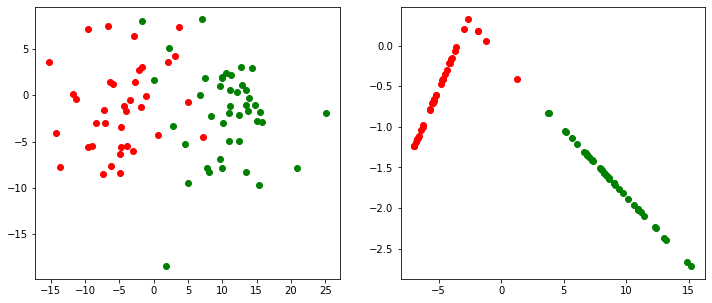

In [105]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(x_ts[y_ts==0][:,0],x_ts[y_ts==0][:,1],c='red')
plt.scatter(x_ts[y_ts==1][:,0],x_ts[y_ts==1][:,1],c='green')
plt.title('Original Data')

plt.subplot(1,2,2)
plt.scatter(reconstructed[y_ts==0][:,0],reconstructed[y_ts==0][:,1],c='red')
plt.scatter(reconstructed[y_ts==1][:,0],reconstructed[y_ts==1][:,1],c='green')
plt.title('Reconstructed Data')

# Extract lower dimensional features

Pass data only through the first layers of the AE to extract lower dimensional features. Convert these features into numpy arrays for training and testing logistic regression.

In [114]:
x_tr_tensor = torch.Tensor(x_tr)
extracted_features_tr = model.layer2(model.layer1(x_tr_tensor))
extracted_features_tr = extracted_features_tr.detach().cpu().numpy()

x_ts_tensor = torch.Tensor(x_ts)
extracted_features_ts = model.layer2(model.layer1(x_ts_tensor))
extracted_features_ts = extracted_features_ts.detach().cpu().numpy()

Train and test logistic regression with extracted features.

accuracy: 0.9875



<AxesSubplot:>

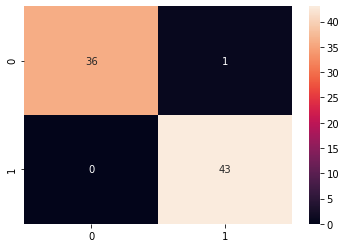

In [115]:
lr = LogisticRegression()
lr.fit(extracted_features_tr,y_tr)
preds = lr.predict(extracted_features_ts)

print('accuracy:', accuracy_score(y_ts,preds))
print('')
sns.heatmap(confusion_matrix(y_ts,preds),annot=True,fmt='1d')

It works. The extracted features contain discriminative information which the model can use to discriminate between different classes. We can now use the AE to extract lower dimensional features and make model training more efficient.

Also, as we see in the plot below, there is evidence that the extracted features are less noisy than the original data, and could be better for training models than the original data.

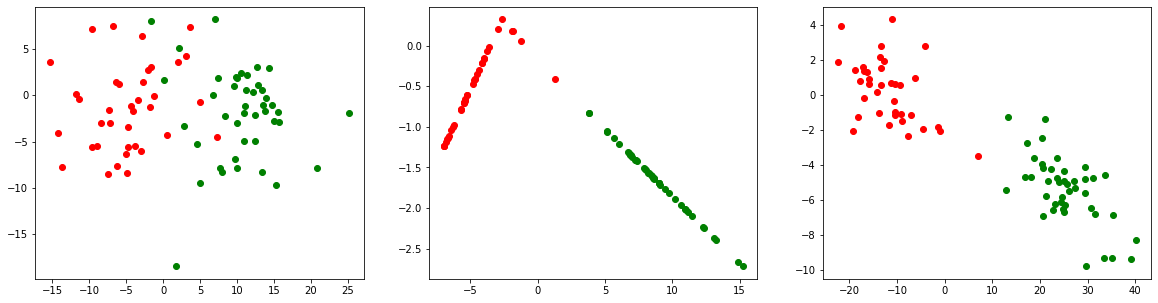

In [120]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(x_ts[y_ts==0][:,0],x_ts[y_ts==0][:,1],c='red')
plt.scatter(x_ts[y_ts==1][:,0],x_ts[y_ts==1][:,1],c='green')

plt.subplot(1,3,2)
plt.scatter(reconstructed[y_ts==0][:,0],reconstructed[y_ts==0][:,1],c='red')
plt.scatter(reconstructed[y_ts==1][:,0],reconstructed[y_ts==1][:,1],c='green')

plt.subplot(1,3,3)
plt.scatter(extracted_features_ts[y_ts==0][:,0],extracted_features_ts[y_ts==0][:,1],c='red')
plt.scatter(extracted_features_ts[y_ts==1][:,0],extracted_features_ts[y_ts==1][:,1],c='green')